In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

from regime_detection import KAMA
from regime_detection import MarkovSwitchingModel

In [3]:
symbol_name_dict = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name'].to_dict()
index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)

close_cols = index_data.columns[index_data.columns.get_level_values(1) == 'close']
index_close_prices = index_data[close_cols].droplevel(1, axis=1).rename(columns=symbol_name_dict)

sp500_prices = index_close_prices['S&P 500'].dropna()

In [8]:
index_close_prices.apply(lambda col: col.dropna().index[0])

S&P/TSX Composite Index   1990-01-02
TSEC Weighted Index       1997-07-02
S&P/ASX 200               1992-11-23
S&P 500                   1990-01-02
Nikkei 225                1990-01-04
KOSPI Composite Index     1990-01-03
FTSE MIB Index            1997-12-31
FTSE 100                  1990-01-02
SMI PR                    1990-11-09
NIFTY 50                  2007-09-17
NASDAQ 100                1990-01-02
DAX Performance Index     1990-01-02
CAC 40                    1999-03-15
MSCI_China                1998-12-31
dtype: datetime64[ns]

# Testing KAMA

In [4]:
kama = KAMA(n=10, n_fast=2, n_slow=30)
sp500_kama = kama.calculate_kama(sp500_prices)
# pd.concat([sp500_prices, sp500_kama[0], sp500_kama[1], sp500_kama[2]], axis=1).head(11)

In [5]:
px.line(pd.concat([sp500_prices, sp500_kama[0]], axis=1).tail(252*5))

# Testing MSR

Fitting Markov Switching Model on S&P 500 data...
Running Gibbs sampler: 275 total iterations
Burnin: 75, Samples: 200, Thin: 1
Iteration 25/275
Iteration 50/275
Iteration 75/275
Iteration 100/275
Iteration 125/275
Iteration 150/275
Iteration 175/275
Iteration 200/275
Iteration 225/275
Iteration 250/275
Iteration 275/275

Gibbs sampling completed!
Regime 0: μ=0.000712, β=-0.0013, σ=0.006545
Regime 1: μ=-0.000653, β=-0.0113, σ=0.017288

ANALYSIS RESULTS FOR S&P 500

Estimated Parameters:
Regime   μ (Mean)     β (AR)     σ (Vol)     
---------------------------------------------
Regime 0  0.000712    -0.0013   0.006545   
Regime 1  -0.000653   -0.0113   0.017288   

Transition Probabilities:
From\To   Regime 0   Regime 1
Regime 0    0.983      0.017
Regime 1    0.039      0.961

Expected Regime Durations:
Regime 0 (Low Vol): 58.1 days
Regime 1 (High Vol): 25.8 days

Regime Classification:
Estimated Regime 0 periods: 4931 days (69.9%)
Estimated Regime 1 periods: 2124 days (30.1%)

Empiric

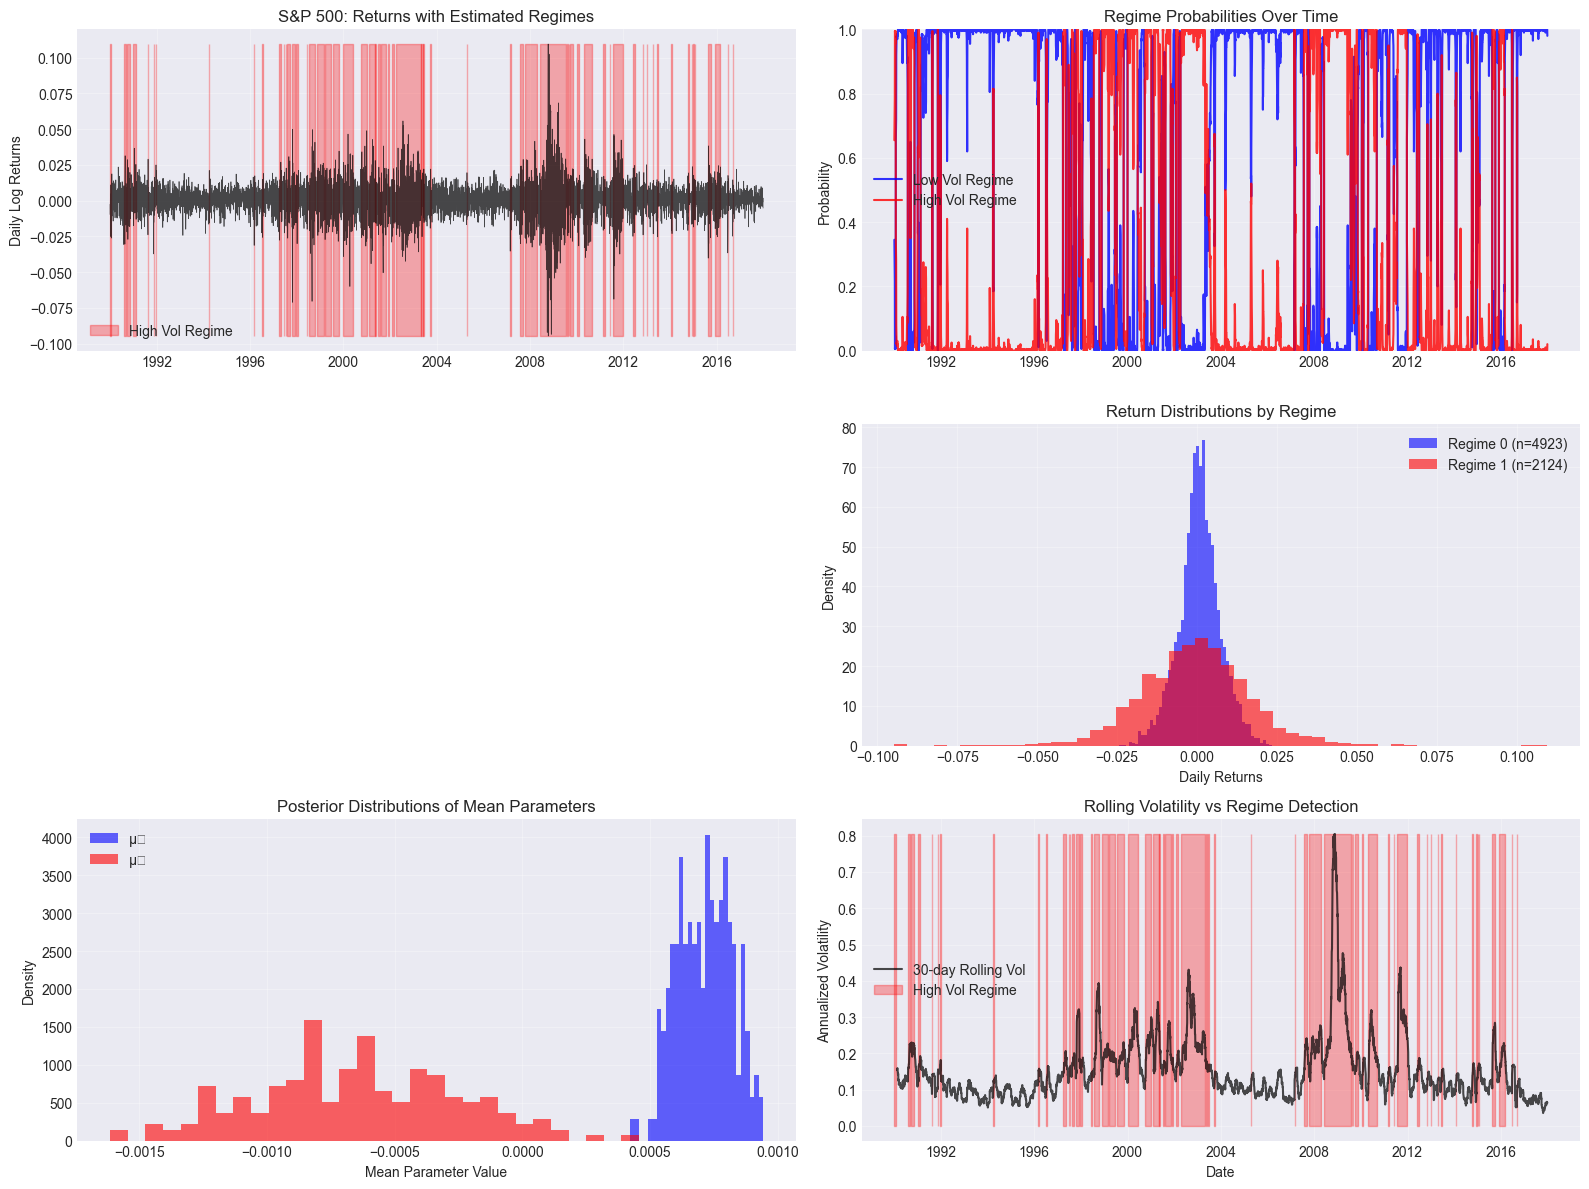


DETAILED REGIME ANALYSIS - S&P 500

Low Volatility Regime (Regime 0):
  Observations: 4931 (69.9%)
  Mean Return: 0.000726 (18.30% annualized)
  Volatility: 0.006517 (10.35% annualized)
  Min Return: -0.024293
  Max Return: 0.023513
  Skewness: -0.069
  Excess Kurtosis: 0.513

High Volatility Regime (Regime 1):
  Observations: 2124 (30.1%)
  Mean Return: -0.000742 (-18.69% annualized)
  Volatility: 0.017556 (27.87% annualized)
  Min Return: -0.094695
  Max Return: 0.109572
  Skewness: -0.050
  Excess Kurtosis: 3.160

Regime Switching Frequency:
  Number of regime changes: 119
  Average regime duration: 58.8 days

MODEL DIAGNOSTICS - S&P 500

Model Fit Statistics:
Approximate Log-Likelihood: 23396.63
Approximate (Average) Log-Likelihood: 3.32

MCMC Convergence Diagnostics:
Number of samples: 200
μ_0 stability: First half = 0.000703, Second half = 0.000720
μ_1 stability: First half = -0.000641, Second half = -0.000665
β_0 stability: First half = -0.001486, Second half = -0.001066
β_1 st

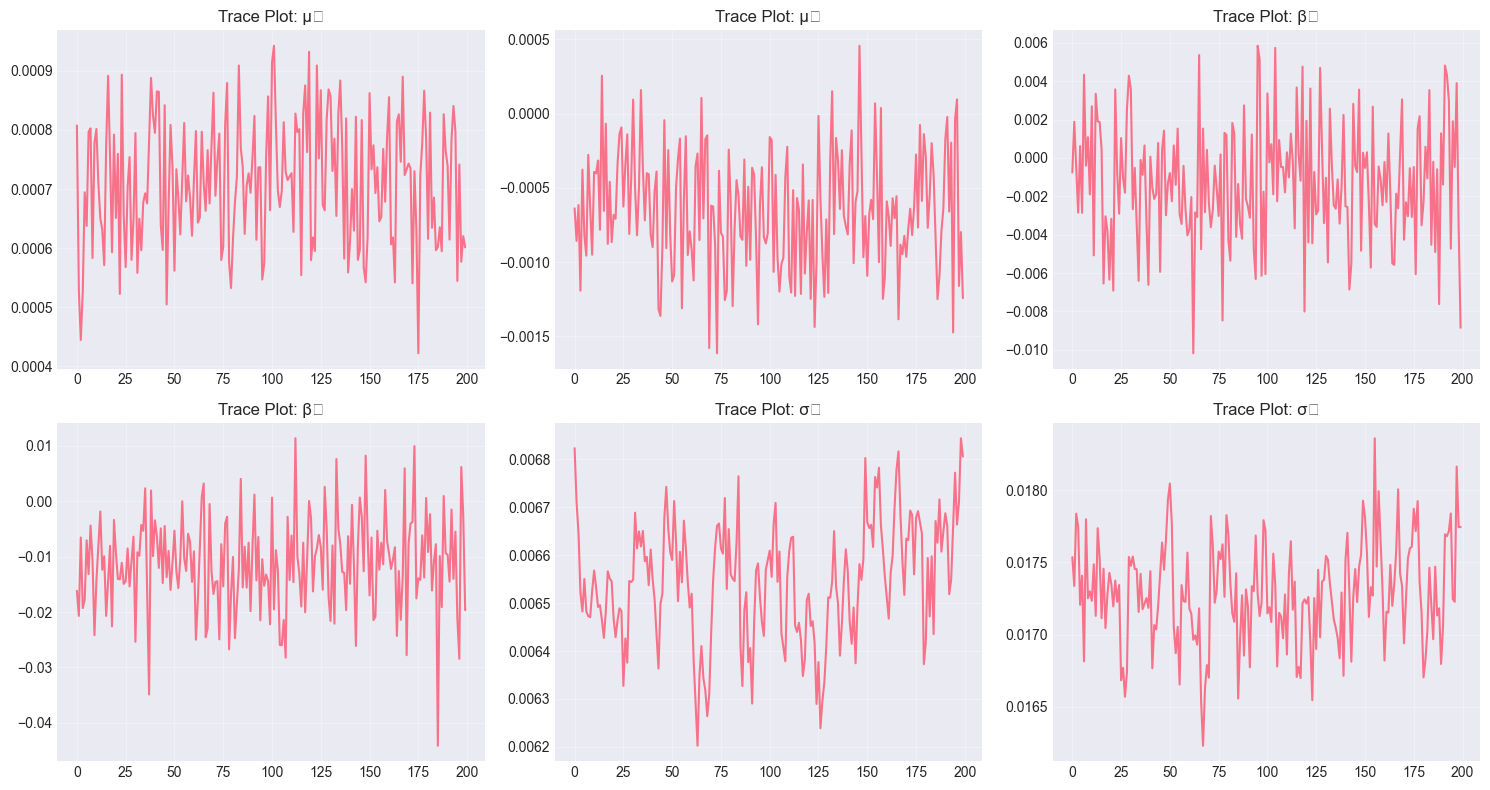


TESTING COMPLETE!


In [9]:
sdte = datetime(1990, 1, 1)
edte = datetime(2018, 1, 1)
# edte = sp500_prices.index[-1]
sp500_log_returns = np.log(sp500_prices).diff().dropna()
sp500_log_returns = pd.DataFrame({'returns': sp500_log_returns.loc[sdte:edte]})

model = MarkovSwitchingModel(n_regimes=2)
model.set_priors(
    mean_prior_mean=0.0,
    mean_prior_var=0.01,
    beta_prior_mean=0.0,
    beta_prior_var=0.3,
    sigma_prior_shape=3.0,
    sigma_prior_scale=0.0001,
    transition_prior_alpha=8.0
)
# Fit the model
print("Fitting Markov Switching Model on S&P 500 data...")
model.fit(sp500_log_returns['returns'], n_samples=200, burnin=75, verbose=True)

# Run comprehensive analysis
regime_probs = model.analyze_results(sp500_log_returns, data_name="S&P 500")

# Create visualizations
model.plot_results(sp500_log_returns, regime_probs, data_name="S&P 500")

# Detailed regime characteristics
regime_classification = model.regime_characteristics(sp500_log_returns, regime_probs, data_name="S&P 500")

# Model diagnostics
model.diagnostics(sp500_log_returns, regime_probs, data_name="S&P 500")

print("\n" + "="*70)
print("TESTING COMPLETE!")
print("="*70)


# Next Section